In [2]:
'''
AUTHOR: Conor Lane, April 2023,  Conor.lane1995@gmail.com
Performs Single Value Decomposition on the epoched traces for a single cell and uses the output to plot frequency and intensity tuning. 
Inputs: takes the dictionary of tuned cells from "cells.pkl", assumes epoch_recording script has been run already.

'''

'\nAUTHOR: Conor Lane, April 2023,  Conor.lane1995@gmail.com\nPerforms Single Value Decomposition on the epoched traces for a single cell and uses the output to plot frequency and intensity tuning. \nInputs: takes the dictionary of tuned cells from "cells.pkl", assumes epoch_recording script has been run already.\n\n'

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import os
from scipy.optimize import curve_fit

INPUT_DESIRED_CELL = 427

In [122]:
cell = "C:/Users/Conor/Documents/Imaging_Data/Two-Photon/Psilocybin_Project/Evoked_Cohort_Mice/ID276/ID276_07032023_Psilocybin/TSeries-03072023-1303-063/suite2p/plane0/cells.pkl"

with open(cell, 'rb') as f:
    cell_dict_1 = pickle.load(f)

In [123]:
#Cell_ID selects the particular cell you want to look at. 
# Accesses the keys for all frequencies, all intensities and all trials. 
cell_ID = cell_dict_1[INPUT_DESIRED_CELL]
cell0 = cell_ID['traces']
nfreq = list(cell_ID['traces'].keys())
nInt = list(cell_ID['traces'][nfreq[0]].keys())
ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [120]:
# all cells and tuning curves 

matrix_all = []

for key in cell_dict_1.keys():
    cell_ID = cell_dict_1[key]
    cell0 = cell_ID['traces']
    nfreq = list(cell_ID['traces'].keys())
    nInt = list(cell_ID['traces'][nfreq[0]].keys())
    ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())

    matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
        # Average the matrix across trials
    matrix_av = matrix.mean(axis=2)

    # Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
    matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)

    # Runs SVD on the reshaped matrix, calculates the percentage variance explained.  If it is below threshold, moves onto next iteration.
    U, S, Vt = np.linalg.svd(matrix_res)
    S = S**2/(S**2).sum()
    if S[0] < 0.2:
        continue


    # matrix_all.append(U[:,0].reshape(-1,1) @ Vt[0,:].reshape(1,-1))
    matrix_all.append(np.abs(U[:,0]))

matrix_all = np.array(matrix_all)

print(matrix_all.shape)



(708, 12)


In [124]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

model = UMAP(metric='euclidean',min_dist=0.1,n_neighbors=30)
matrix_norm = StandardScaler().fit_transform(matrix_all.reshape(matrix_all.shape[0],-1).T).T
model.fit(matrix_norm) # First dimension is cells, second dimension is everything else. 

UMAP(n_neighbors=30, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


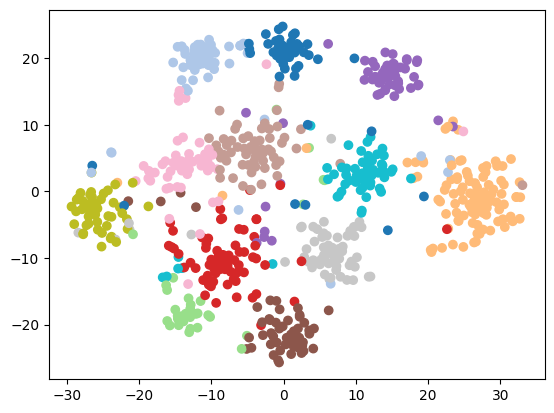

In [113]:
from sklearn.manifold import TSNE

model2 = TSNE()
matrix_norm = StandardScaler().fit_transform(matrix_all.reshape(matrix_all.shape[0],-1).T).T
# model2.fit(matrix_norm) # First dimension is cells, second dimension is everything else. 

embedded2= model2.fit_transform(matrix_norm)

colours = np.mod(np.argmax(matrix_norm,axis=1),12)/12

plt.scatter(embedded2[:,0],embedded2[:,1],color=plt.cm.tab20(colours))

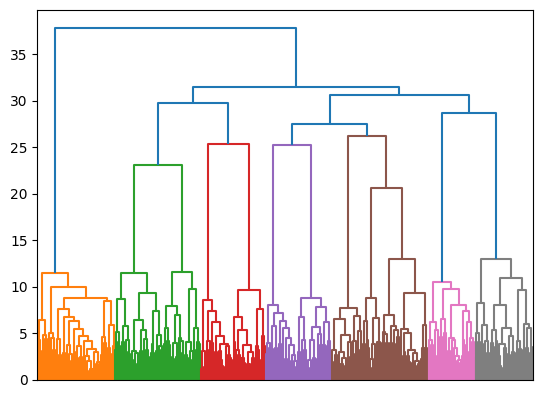

In [114]:
idx = np.argsort(np.argmax(matrix_norm,axis=1))

#plt.imshow(matrix_norm[idx],aspect='auto')

from scipy.cluster.hierarchy import linkage,dendrogram

z = linkage(matrix_norm,method='ward')
dend = dendrogram(z,no_labels=True)

(708,)


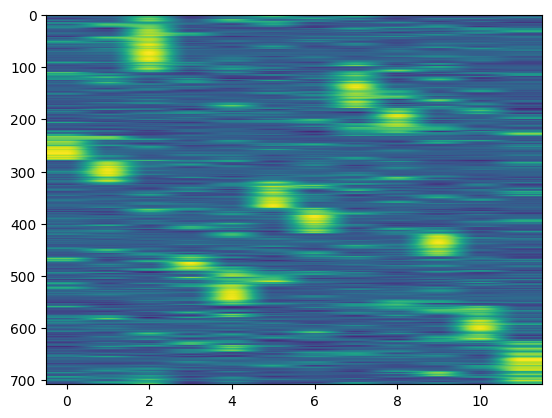

In [115]:
labels = np.array(dend['leaves']).astype(int)
print(labels.shape)

import seaborn as sns

plt.imshow(matrix_norm[labels],aspect='auto')
# sns.clustermap(matrix_norm)

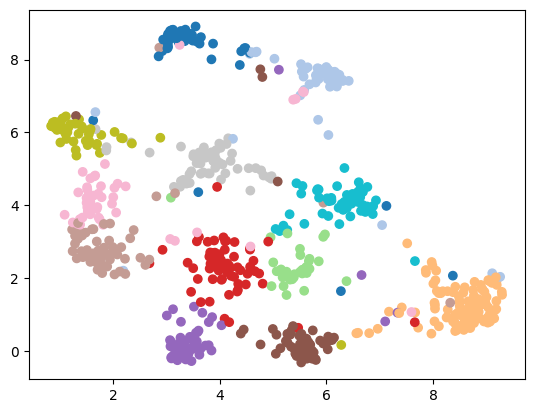

In [118]:
embedded = model.transform(matrix_norm)
colours = np.mod(np.argmax(matrix_norm,axis=1),12)/12

plt.scatter(embedded[:,0],embedded[:,1],color=plt.cm.tab20(colours))


# The cells cluster (they're not randomly distributed)

In [119]:
# Create a matrix of dimensions nFreq x nInte x nTrials to apply SVD to. 

matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
print(matrix.shape)

(12, 4, 10, 15)


In [7]:
# Average the matrix across trials
matrix_av = matrix.mean(axis=2)

# Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)
print(matrix_av.shape)
print(matrix_res.shape)

(12, 4, 15)
(12, 4)


(12, 12) (4,) (4, 4)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '4364'),
  Text(1, 0, '5371'),
  Text(2, 0, '6612'),
  Text(3, 0, '8140'),
  Text(4, 0, '10020'),
  Text(5, 0, '12335'),
  Text(6, 0, '15184'),
  Text(7, 0, '18691'),
  Text(8, 0, '23009'),
  Text(9, 0, '28324'),
  Text(10, 0, '34867'),
  Text(11, 0, '42922')])

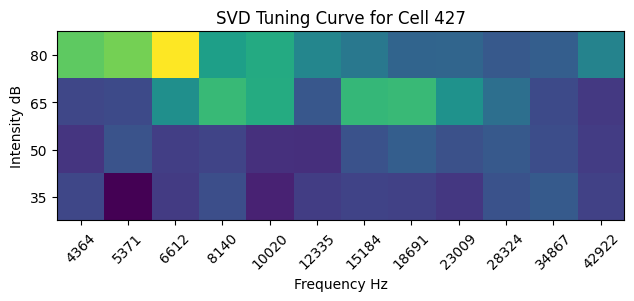

In [8]:
#Run Single Value Decomposition on the reshaped matrix and plot the resulting tuning heatmap. 

U, S, Vt = np.linalg.svd(matrix_res)
print(U.shape, S.shape, Vt.shape)
fig, ax = plt.subplots()
plt.tight_layout()
plt.imshow(matrix_res.T)
plt.gca().invert_yaxis()
plt.title("SVD Tuning Curve for Cell " + str(INPUT_DESIRED_CELL))
plt.xlabel("Frequency Hz")
plt.ylabel("Intensity dB")
plt.yticks(np.arange(len(nInt)))
plt.xticks(np.arange(len(nfreq)))
ax.set_xticklabels(nfreq)
ax.set_yticklabels(nInt)
plt.xticks(rotation = 45)



C:\Users\Conor\AppData\Local\Temp\ipykernel_16380\1812131554.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(nInt)


(12, 12)


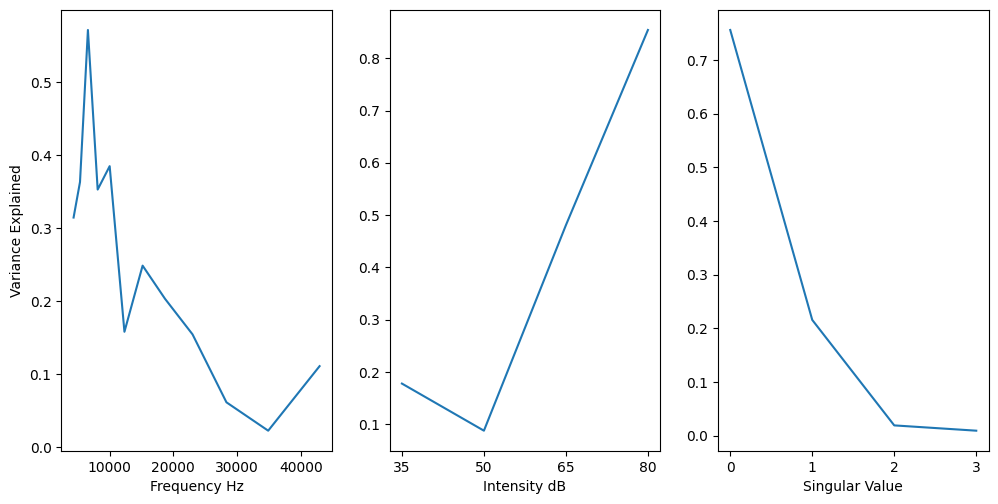

In [9]:
# Left: Plots the tuning curve of the cell (inverted so it looks classical), Middle: Plots the intensity tuning of the cell. Right: The level of significance of each 
# component, e.g. if the line starts close to 1.0, it means most of the variation is explained by the first component - cell is highly frequency tuned. 

U, S, Vt = np.linalg.svd(matrix_res)
fig, ax = plt.subplots(ncols=3, figsize=(10,5))
plt.tight_layout()
ax[0].plot(nfreq, np.abs(U[:,0]))
ax[0].set_xlabel("Frequency Hz")
ax[0].set_ylabel("Variance Explained")
ax[1].plot(np.abs(Vt[0]))
ax[1].set_xlabel("Intensity dB")
ax[1].set_xticklabels(nInt)
ax[1].set_xticks(np.arange(len(nInt)))
ax[2].plot(S**2/(S**2).sum())  # % Variance explained.  Eigenvalues = square of the singular values. Actual variance, divide this by n-1 where n= no. rows
ax[2].set_xlabel("Singular Value")

print(U.shape)

In [10]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    theta=0
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [11]:
amplitude = np.sum(matrix_res)
xo = 3
yo = 7
sigma_x = 1
sigma_y = 1
theta = 0
offset = np.min(matrix_res)

x,y = np.meshgrid(np.arange(4),np.arange(12))

popt, pcov = curve_fit(twoD_Gaussian, (x, y), matrix_res.flatten(), p0=(amplitude,xo,yo,sigma_x,sigma_y,theta,offset), maxfev=5000)

C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[110.27412483   2.54469975   1.93837832   0.3056997    4.44526918
   0.          -2.82863047]
[[inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]]
0.7571525528692578


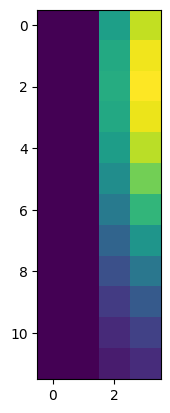

In [12]:
print(popt)
print(pcov)
x,y = np.meshgrid(np.arange(4),np.arange(12))
plt.imshow(twoD_Gaussian((x,y),*popt).reshape(12,4))
from scipy.stats import pearsonr
print(pearsonr(twoD_Gaussian((x,y),*popt).reshape(12,4).mean(axis=1), np.abs(U[:,0])*popt[0])[0]**2)
# amplitude = AUC
# xo = preferred int
# yo = preferred freq
# sigma_x = int 
# sigma_y = width freq - stddev so how many freqs are within 65% of curve
# theta = rotation of gaussian
# offset = background baseline flourescence